# Preparing CiMo Input

This file tries to perform the steps that need to be performed manually with ArcGIS at the current moment (2016-07-25) with Python only. That would make the steps easily reproducible.

In [1]:
import geopandas as gpd
import eecisc
%matplotlib inline
import seaborn as sns

In [2]:
POSTCODE_PATH = '/notebooks/LondonPCLSOA.shp'
LSOA_PATH = '/notebooks/LA_AUTHORITY_LSOA.shp'
TILE_PATH = '/notebooks/HB0616_UKMap_Topo_Base_Table.shp'
OUTPUT_FILE = './build/sjoin_selection.shp'

## Read in Data

In [3]:
postcode = eecisc.read_shapefile(POSTCODE_PATH)
lsoa = eecisc.read_shapefile(LSOA_PATH)
tile = eecisc.read_shapefile(TILE_PATH)

User name on eecisc: tt397
Password: ········
User name on eecisc: tt397
Password: ········
User name on eecisc: tt397
Password: ········


In [4]:
postcode.index.size

168251

In [5]:
lsoa.index.size

4765

In [6]:
tile.index.size

220175

In [7]:
postcode.crs

{}

In [8]:
lsoa.crs

{'datum': 'OSGB36',
 'k': 0.9996012717,
 'lat_0': 49,
 'lon_0': -2,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 400000,
 'y_0': -100000}

In [9]:
tile.crs

{'datum': 'OSGB36',
 'k': 0.9996012717,
 'lat_0': 49,
 'lon_0': -2,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 400000,
 'y_0': -100000}

The postcode dataset does not have a coordinate reference system (CRS) attached to it. The CRS from the london authority dataset and from UKMap match.

In [10]:
postcode.crs = tile.crs # Postcode dataset is known to be OSGB36 as well.

## Filter out Buildings

In [11]:
buildings_in_tile = tile[tile.FTC == 1]

In [12]:
buildings_in_tile.index.size

113057

## Spatial Join

### Super Output Area

In [13]:
spatial_join = gpd.sjoin(buildings_in_tile, lsoa)
# FIXME not very smart deduplication, rather keep the more appropriate (bigger intersect?)
spatial_join = spatial_join[~spatial_join.index.duplicated(keep='first')]
assert spatial_join.index.size == buildings_in_tile.index.size

In [14]:
needed_columns = list(buildings_in_tile.columns) + ['LSOA_CODE']
spatial_join = spatial_join[needed_columns]
assert list(spatial_join.columns) == needed_columns
assert spatial_join.index.size == buildings_in_tile.index.size

### Postcode

In [15]:
spatial_join = gpd.sjoin(spatial_join, postcode)
# FIXME not very smart deduplication, rather keep the more appropriate (bigger intersect?)
spatial_join = spatial_join[~spatial_join.index.duplicated(keep='first')]
assert spatial_join.index.size == buildings_in_tile.index.size

In [16]:
spatial_join.rename(columns=lambda x: x.replace('_left', ''), inplace=True) # remove traces from join on 'left' columns
needed_columns = list(buildings_in_tile.columns) + ['LSOA_CODE', 'POSTCODE']
spatial_join = spatial_join[needed_columns]
assert list(spatial_join.columns) == needed_columns
assert spatial_join.index.size == buildings_in_tile.index.size

## Select Small Area for Tests

In [17]:
smallest_x = min([polygon.centroid.coords.xy[0] for polygon in spatial_join.geometry])[0]
smallest_y = min([polygon.centroid.coords.xy[1] for polygon in spatial_join.geometry])[0]

In [18]:
from shapely.geometry.polygon import Polygon

In [19]:
length = 300
window = gpd.GeoDataFrame(geometry=[Polygon([(smallest_x, smallest_y), 
                                             (smallest_x + length, smallest_y), 
                                             (smallest_x + length, smallest_y + length), 
                                             (smallest_x, smallest_y + length)])])
window.crs = spatial_join.crs

In [20]:
selection = gpd.sjoin(spatial_join, window)

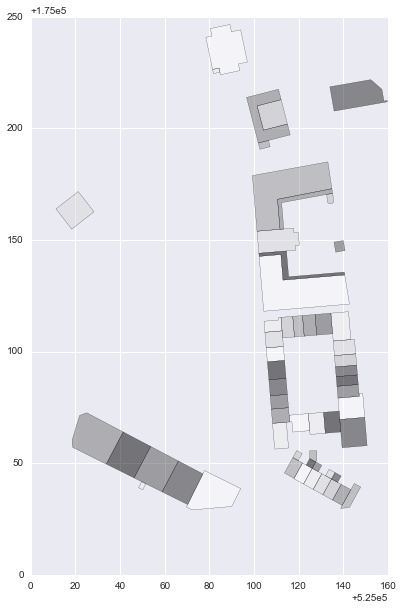

In [21]:
selection.plot(figsize=(10, 10), linewidth=0.2)

In [22]:
selection.index.size

56

## Export

The file exported with GeoPandas is currently not directly usable for CiMo. That's because data type information doesn't seem to be transmitted properly. Geopandas does not have a problem when using (reimporting) the exported file. Neither does ArcMap. ArcPy's SearchCursor (``arcpy.da.SearchCursor``) from ArcGIS 12.2.2 unfortunately does not import the file properly: many (or all) integers are turned into floats.

In [24]:
selection.to_file(OUTPUT_FILE)

## Creating Surrounding Bounds

This is to be able to use it in ArcGIS.

In [25]:
selection.total_bounds

(525011.27000000002, 175029.06, 525159.75, 175246.54999999999)

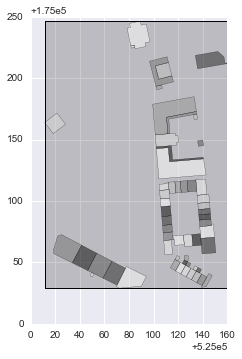

In [26]:
minx, miny, maxx, maxy = selection.total_bounds
p = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])
surrounding_bounds = gpd.GeoDataFrame(geometry=[p])
surrounding_bounds.crs = spatial_join.crs
ax = surrounding_bounds.plot(alpha=0.2)
selection.plot(linewidth=0.2, ax=ax)